Limeng Yang & Rik van Rhee

Jupyter Notebook used for the measurements of our experiment.

In [1]:
# Import statements

import pandas as pd
import matplotlib.pyplot as plt
from lmfit import models
from scipy.signal import find_peaks

First we will use the calibration data to convert the time axis in our data to a frequency axis.

In [2]:
# Open calibration data

df_calib = pd.read_csv('Data 01-12-23/Calibration_Data.csv', header=None, usecols=[3,4,9,10])


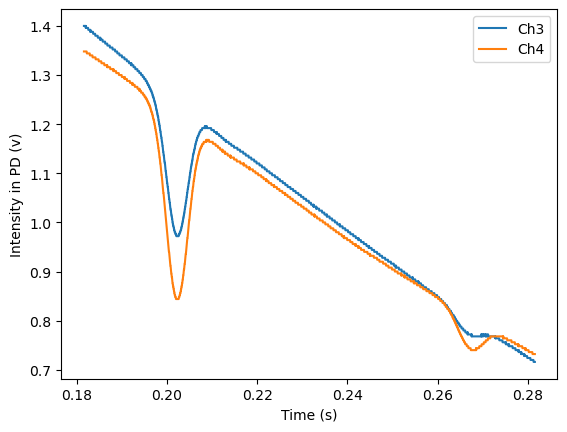

In [3]:
# Show the data in a graph

plt.plot(df_calib[3],df_calib[4], label="Ch3")
plt.plot(df_calib[9],df_calib[10], label="Ch4")
plt.xlabel("Time (s)")
plt.ylabel("Intensity in PD (v)")
plt.legend()

To convert the time axis to frequency, we will fit these curves with a linear fit and two Gaussian fits. From this we can take the found center points of the Gaussian dips and compare the difference in these dips to the known difference in frequency of these. This is $6834.7$ MHz.

In [4]:
# Define the fitfunctions

def LinFunc(x, a, b):
    y = a*x+b
    return y

Lin_model = models.Model(LinFunc)
gauss_model_1 = models.GaussianModel(prefix="A_")
gauss_model_2 = models.GaussianModel(prefix="B_")

tot_model = Lin_model + gauss_model_1 + gauss_model_2

print(f'parameter names: {tot_model.param_names}')
print(f'independent variables: {tot_model.independent_vars}')

parameter names: ['a', 'b', 'A_amplitude', 'A_center', 'A_sigma', 'B_amplitude', 'B_center', 'B_sigma']
independent variables: ['x']


In [5]:
# Set some initial parameters from observation

a = (df_calib[4][0]-df_calib[4][len(df_calib[4])-1])/(df_calib[3][0]-df_calib[3][len(df_calib[3])-1]) 
b = 1.7
A_amp = -0.3
A_center = 0.20
A_sigma = 0.005
B_amp = -0.05
B_center = 0.27
B_sigma = 0.005

In [6]:
# Fit the data with the models
result_1= tot_model.fit(df_calib[4], x=df_calib[3], a=a, b=b, A_amplitude=A_amp, A_center=A_center, A_sigma=A_sigma, B_amplitude=-3.6906e-04, B_center=B_center, B_sigma=B_sigma)
result_2= tot_model.fit(df_calib[10], x=df_calib[9], a=a, b=b, A_amplitude=A_amp, A_center=A_center, A_sigma=A_sigma, B_amplitude=B_amp, B_center=B_center, B_sigma=B_sigma)


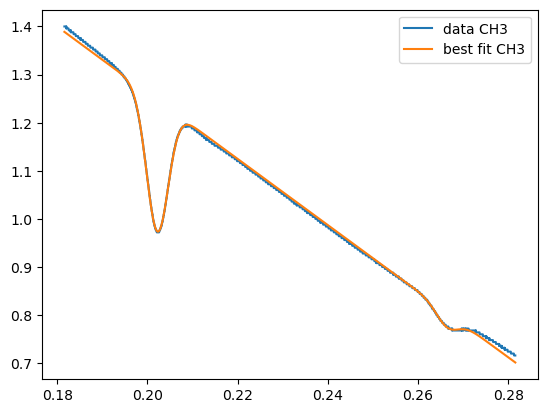

In [7]:
# Plot the first fit
plt.plot(df_calib[3], df_calib[4], label='data CH3')
plt.plot(df_calib[3], result_1.best_fit, '-', label='best fit CH3')
plt.legend()

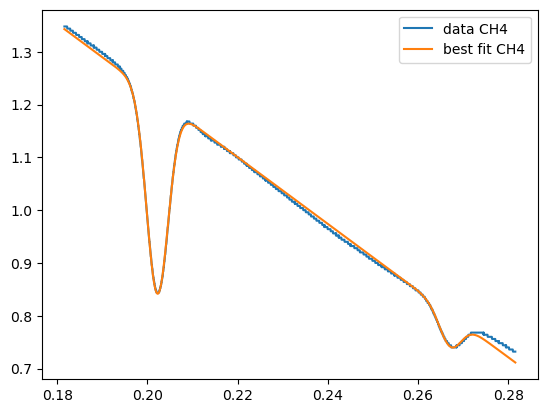

In [8]:
# Plot the second fit
plt.plot(df_calib[9], df_calib[10], label='data CH4')
plt.plot(df_calib[9], result_2.best_fit, '-', label='best fit CH4')
plt.legend()

In [9]:
# Compare the centers of the two fits

A_center_1 = result_1.params.get("A_center").value
A_center_2 = result_2.params.get("A_center").value
B_center_1 = result_1.params.get("B_center").value
B_center_2 = result_2.params.get("B_center").value

print(f"The first peak in the two fits have centers at {A_center_1} and {A_center_2}")
print(f"The second peak in the two fits have centers at {B_center_1} and {B_center_2}")

The first peak in the two fits have centers at 0.20219458277731212 and 0.2021899339311211
The second peak in the two fits have centers at 0.2664421875965511 and 0.26709022466180377


These centers are close to each other, so we will take the mean

In [10]:
peak_A = (A_center_1+A_center_2)/2
peak_B = (B_center_1+B_center_2)/2

We can thus convert between the time axis and the frequency axis by using:
\begin{equation}
f = \frac{\Delta f}{\Delta t} t.
\end{equation}
We will use $\frac{\Delta f}{\Delta t}=Q$ for notation.


In [11]:
delta_f = 6834.7 #MHz
delta_t = abs(peak_A-peak_B)
Q = delta_f/delta_t
Q

105842.99451256749

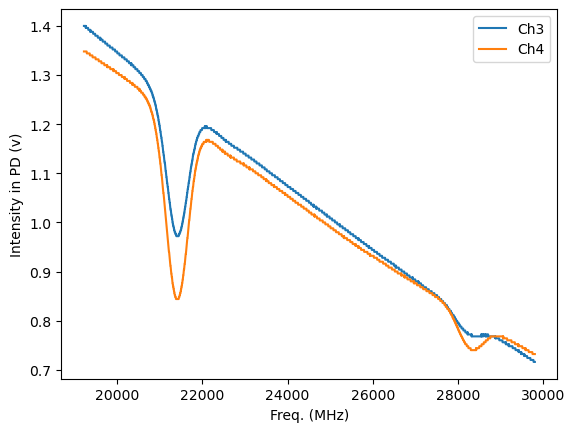

In [12]:
# Converting the axis for the calibration data
df_calib["freq1"]=Q*df_calib[3]
df_calib["freq2"]=Q*df_calib[9]

# Plotting this data
plt.plot(df_calib["freq1"],df_calib[4], label="Ch3")
plt.plot(df_calib["freq2"],df_calib[10], label="Ch4")
plt.xlabel("Freq. (MHz)")
plt.ylabel("Intensity in PD (v)")
plt.legend()

For each dataset we will further use, we can thus convert the time axis to frequency axis.

We will now open each recorded measurement at different currents. We will find the peaks of the $F=3$ lines and calculate the difference. These differences we will add to a list which we will plot against a list of the used currents.

In [13]:
# First create the list of frequencies en list of currents
Currents = [0, 0.105, 0.206, 0.3, 0.408, 0.508, 0.6]
Frequencies = []

In [14]:
# First the dataset without a current
df_nocur =  pd.read_csv('Data 01-12-23/No_Current_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_nocur["freq1"]=df_nocur[3]*Q
df_nocur["freq2"]=df_nocur[9]*Q

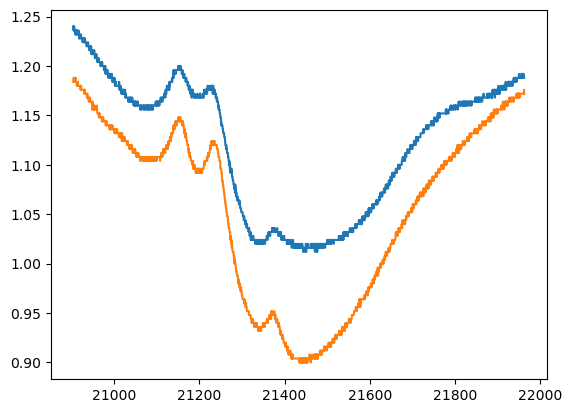

In [15]:
# Plot this data

plt.plot(df_nocur["freq1"], df_nocur[4], label="CH3")
plt.plot(df_nocur["freq2"], df_nocur[10], label="CH4")

In [16]:
# Use an online tool to help find peaks
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_nocur[4], lookahead=100)
peaks2 = peakdetect(df_nocur[10], lookahead=100)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

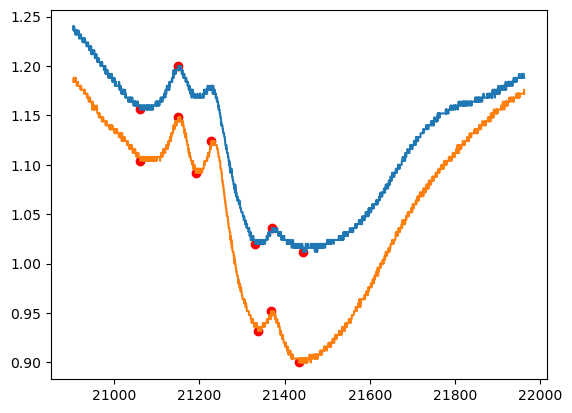

In [17]:
# Plot the data with the found peaks
plt.plot(df_nocur["freq1"], df_nocur[4], "-")
plt.scatter(df_nocur["freq1"][indices1], df_nocur[4][indices1], color="red")

plt.plot(df_nocur["freq2"], df_nocur[10], "-")
plt.scatter(df_nocur["freq2"][indices2], df_nocur[10][indices2], color="red")

From this we can see that the peak we want is found. We will then, per datafile, manually get this peak and add the difference to a list.

In [18]:
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_nocur["freq1"][index]<21500:
        sive1_freq.append(df_nocur["freq1"][index])
        sive1_inten.append(df_nocur[4][index])
for index in indices2:
    if 21300<df_nocur["freq2"][index]<21500:
        sive2_freq.append(df_nocur["freq1"][index])
        sive2_inten.append(df_nocur[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
Frequencies.append(diff)

# Frequency of peak, used later for varifying the F=3 peak
Peak_F3=(sive1_freq[save1_index]+sive2_freq[save2_index])/2

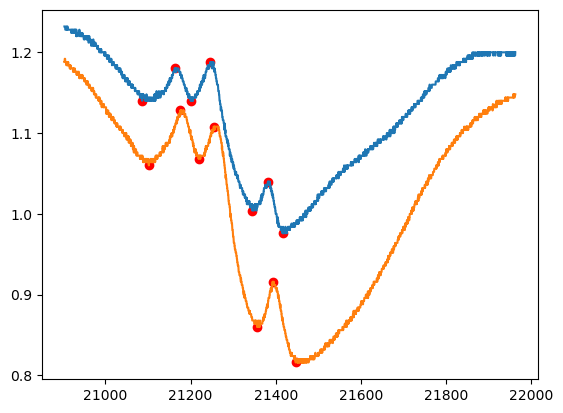

In [19]:
# Now data with about 1 Ampere
df_1Amp =  pd.read_csv('Data 01-12-23/0.105Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_1Amp["freq1"]=df_1Amp[3]*Q
df_1Amp["freq2"]=df_1Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_1Amp[4], lookahead=100)
peaks2 = peakdetect(df_1Amp[10], lookahead=100)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_1Amp["freq1"], df_1Amp[4], "-")
plt.scatter(df_1Amp["freq1"][indices1], df_1Amp[4][indices1], color="red")
plt.plot(df_1Amp["freq2"], df_1Amp[10], "-")
plt.scatter(df_1Amp["freq2"][indices2], df_1Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_1Amp["freq1"][index]<21500:
        sive1_freq.append(df_1Amp["freq1"][index])
        sive1_inten.append(df_1Amp[4][index])
for index in indices2:
    if 21300<df_1Amp["freq2"][index]<21500:
        sive2_freq.append(df_1Amp["freq1"][index])
        sive2_inten.append(df_1Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
Frequencies.append(diff)

21395.950223103373 21409.498229068686


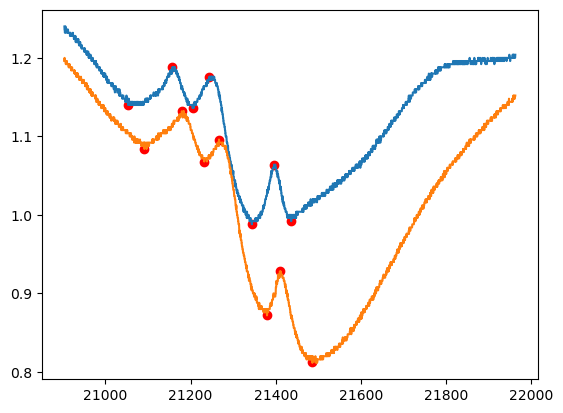

In [34]:
# Now data with about 2 Ampere
df_2Amp =  pd.read_csv('Data 01-12-23/0.206Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_2Amp["freq1"]=df_2Amp[3]*Q
df_2Amp["freq2"]=df_2Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_2Amp[4], lookahead=100)
peaks2 = peakdetect(df_2Amp[10], lookahead=100)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_2Amp["freq1"], df_2Amp[4], "-")
plt.scatter(df_2Amp["freq1"][indices1], df_2Amp[4][indices1], color="red")
plt.plot(df_2Amp["freq2"], df_2Amp[10], "-")
plt.scatter(df_2Amp["freq2"][indices2], df_2Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_2Amp["freq1"][index]<21500:
        sive1_freq.append(df_2Amp["freq1"][index])
        sive1_inten.append(df_2Amp[4][index])
for index in indices2:
    if 21300<df_2Amp["freq2"][index]<21500:
        sive2_freq.append(df_2Amp["freq1"][index])
        sive2_inten.append(df_2Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
print(sive1_freq[save1_index], sive2_freq[save2_index])
Frequencies.append(diff)

21403.571173789893 21423.04623609243


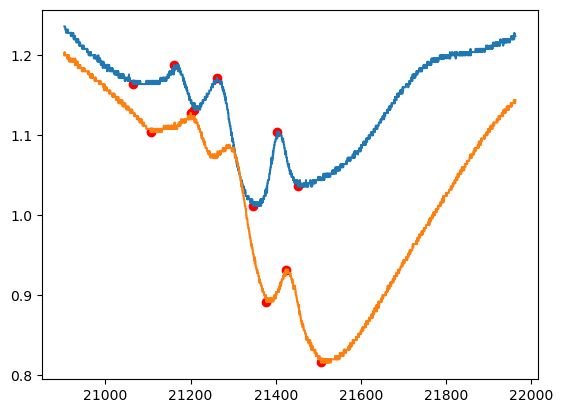

In [33]:
# Now data with about 3 Ampere
df_3Amp =  pd.read_csv('Data 01-12-23/0.300Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_3Amp["freq1"]=df_3Amp[3]*Q
df_3Amp["freq2"]=df_3Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_3Amp[4], lookahead=100)
peaks2 = peakdetect(df_3Amp[10], lookahead=100)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_3Amp["freq1"], df_3Amp[4], "-")
plt.scatter(df_3Amp["freq1"][indices1], df_3Amp[4][indices1], color="red")
plt.plot(df_3Amp["freq2"], df_3Amp[10], "-")
plt.scatter(df_3Amp["freq2"][indices2], df_3Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_3Amp["freq1"][index]<21500:
        sive1_freq.append(df_3Amp["freq1"][index])
        sive1_inten.append(df_3Amp[4][index])
for index in indices2:
    if 21300<df_3Amp["freq2"][index]<21500:
        sive2_freq.append(df_3Amp["freq1"][index])
        sive2_inten.append(df_3Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
print(sive1_freq[save1_index], sive2_freq[save2_index])
Frequencies.append(diff)

21396.37290816039 21420.082707394602


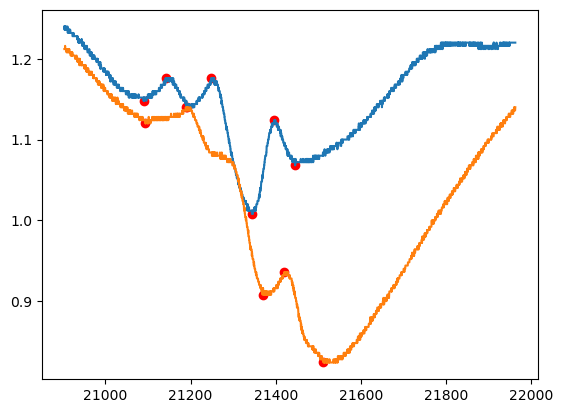

In [32]:
# Now data with about 4 Ampere
df_4Amp =  pd.read_csv('Data 01-12-23/0.408Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_4Amp["freq1"]=df_4Amp[3]*Q
df_4Amp["freq2"]=df_4Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_4Amp[4], lookahead=100)
peaks2 = peakdetect(df_4Amp[10], lookahead=100)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_4Amp["freq1"], df_4Amp[4], "-")
plt.scatter(df_4Amp["freq1"][indices1], df_4Amp[4][indices1], color="red")
plt.plot(df_4Amp["freq2"], df_4Amp[10], "-")
plt.scatter(df_4Amp["freq2"][indices2], df_4Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_4Amp["freq1"][index]<21500:
        sive1_freq.append(df_4Amp["freq1"][index])
        sive1_inten.append(df_4Amp[4][index])
for index in indices2:
    if 21300<df_4Amp["freq2"][index]<21500:
        sive2_freq.append(df_4Amp["freq1"][index])
        sive2_inten.append(df_4Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
print(sive1_freq[save1_index], sive2_freq[save2_index])
Frequencies.append(diff)

21395.950223103373 21427.27939596349


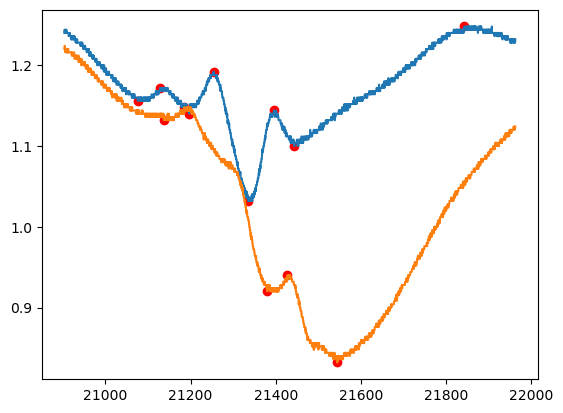

In [31]:
# Now data with about 5 Ampere
df_5Amp =  pd.read_csv('Data 01-12-23/0.509Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_5Amp["freq1"]=df_5Amp[3]*Q
df_5Amp["freq2"]=df_5Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_5Amp[4], lookahead=100)
peaks2 = peakdetect(df_5Amp[10], lookahead=50)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_5Amp["freq1"], df_5Amp[4], "-")
plt.scatter(df_5Amp["freq1"][indices1], df_5Amp[4][indices1], color="red")
plt.plot(df_5Amp["freq2"], df_5Amp[10], "-")
plt.scatter(df_5Amp["freq2"][indices2], df_5Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_5Amp["freq1"][index]<21500:
        sive1_freq.append(df_5Amp["freq1"][index])
        sive1_inten.append(df_5Amp[4][index])
for index in indices2:
    if 21300<df_5Amp["freq2"][index]<21500:
        sive2_freq.append(df_5Amp["freq1"][index])
        sive2_inten.append(df_5Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
print(sive1_freq[save1_index], sive2_freq[save2_index])
Frequencies.append(diff)

21397.644117452674 21438.710822522487


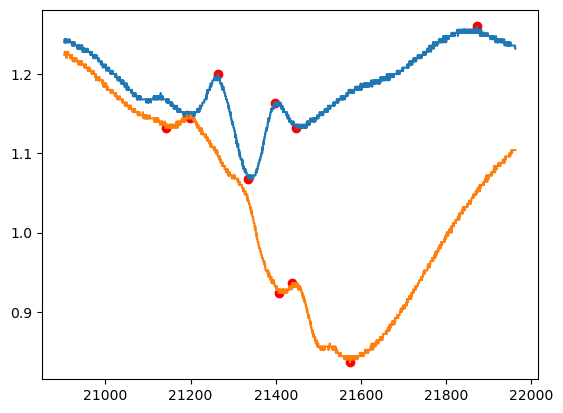

In [30]:
# Now data with about 6 Ampere
df_6Amp =  pd.read_csv('Data 01-12-23/0.600Amp_Data.csv', header=None, usecols=[3,4,9,10])

# Convert the time to freq
df_6Amp["freq1"]=df_6Amp[3]*Q
df_6Amp["freq2"]=df_6Amp[9]*Q

# Use tool
from peakdetect_online import peakdetect
peaks1 = peakdetect(df_6Amp[4], lookahead=100)
peaks2 = peakdetect(df_6Amp[10], lookahead=50)

indices1 = []
indices2 = []
# Filter out only the indices
for p in peaks1:
    for d in p:
        indices1.append(d[0])
for p in peaks2:
    for d in p:
        indices2.append(d[0])

# Plot the data with the found peaks
plt.plot(df_6Amp["freq1"], df_6Amp[4], "-")
plt.scatter(df_6Amp["freq1"][indices1], df_6Amp[4][indices1], color="red")
plt.plot(df_6Amp["freq2"], df_6Amp[10], "-")
plt.scatter(df_6Amp["freq2"][indices2], df_6Amp[10][indices2], color="red")

# Sive out the desired peaks and find the differnce in frequency
sive1_freq=[]
sive1_inten=[]
sive2_freq=[]
sive2_inten=[]

for index in indices1:
    if 21300<df_6Amp["freq1"][index]<21500:
        sive1_freq.append(df_6Amp["freq1"][index])
        sive1_inten.append(df_6Amp[4][index])
for index in indices2:
    if 21300<df_6Amp["freq2"][index]<21500:
        sive2_freq.append(df_6Amp["freq1"][index])
        sive2_inten.append(df_6Amp[4][index])
        
for index in range(len(sive1_freq)-1):
    if sive1_inten[index]==max(sive1_inten):
        save1_index=index
for index in range(len(sive2_freq)-1):
    if sive2_inten[index]==max(sive2_inten):
        save2_index=index

diff = abs(sive1_freq[save1_index]-sive2_freq[save2_index])
print(sive1_freq[save1_index], sive2_freq[save2_index])
Frequencies.append(diff)

We now have 2 lists, one with currents and one with difference of frequencies. We can now plot this.

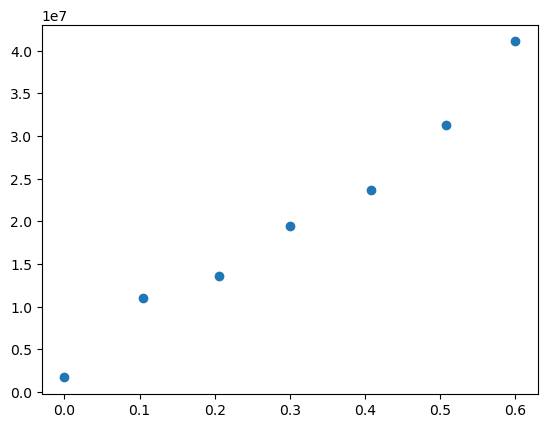

In [25]:
# Convert from MHz to Hz
Frequencies_in_Hz=[]
for freq in Frequencies:
    Frequencies_in_Hz.append(freq*1e6)


plt.scatter(Currents, Frequencies_in_Hz)

This looks quite linear. And according to our hypothesis, the relation should be:
\begin{equation}
\Delta\nu = \frac{\mu_B\mu_0N\Delta M}{lh}I.
\end{equation}
Where that fractioned term is a constant.

We will now try to fit a linear fit through this data.

[[Model]]
    Model(LinFunc)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 7
    # variables        = 1
    chi-square         = 3.5328e+13
    reduced chi-square = 5.8880e+12
    Akaike info crit   = 206.748555
    Bayesian info crit = 206.694465
    R-squared          = 0.96613798
[[Variables]]
    a:  64675515.1 +/- 2518917.47 (3.89%) (init = 6000000)
    b:  0 (fixed)


<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Limeng Yang\AppData\Local\Temp\ipykernel_7692\4188863211.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$Frequency (Hz)")


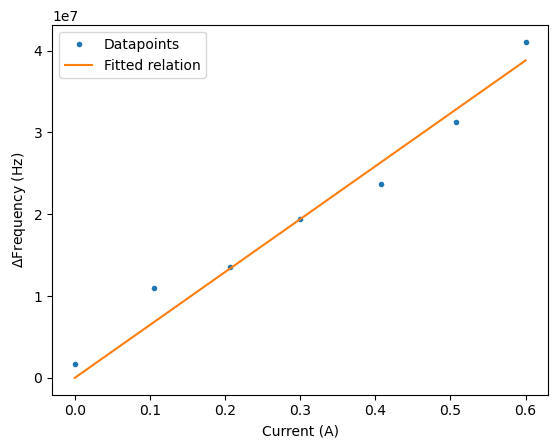

In [26]:
# Make it so b=0
Lin_model.set_param_hint('b', vary=False)

# Use the previous linear fit
LinFit = Lin_model.fit(Frequencies_in_Hz, x=Currents, a=6e6, b=0)

print(LinFit.fit_report())

plt.plot(Currents, Frequencies_in_Hz, '.', label="Datapoints")
plt.plot(Currents, LinFit.best_fit, '-', label='Fitted relation')

plt.xlabel("Current (A)")
plt.ylabel("$\Delta$Frequency (Hz)")

plt.legend()


In [27]:
# Hypothetical constant(lieanr coeffiecient)
MuB = 9.274e-24
Mu0=1.2566e-6
N=1000
DeltaM=3.5
l=0.073
h=6.626e-34

const=(MuB*Mu0*N*DeltaM)/(l*h)
const

843253009.1089897

We also want to check if the $F=3$ peak is the one we used. We already assumed this, with good arguments like our python code "Peak_finder.ipynb". We will also use this data to varify this. We will use the data with no current flowing and set the used peak to the theoretical value of $193.741$ MHz and see if the crossover peaks line up.

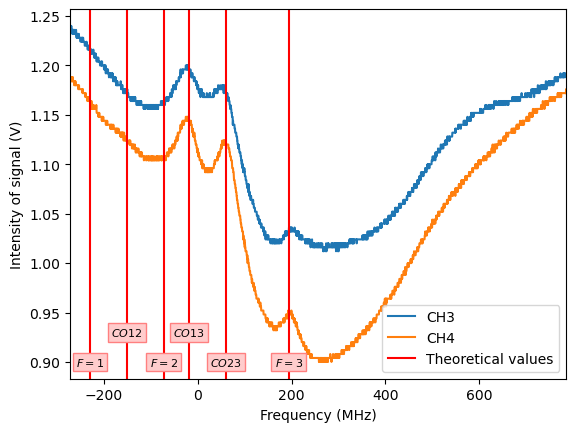

In [28]:
shift_amount = 193.741 - Peak_F3

df_nocur["shifted_freq1"]=df_nocur["freq1"] + shift_amount
df_nocur["shifted_freq2"]=df_nocur["freq2"] + shift_amount

plt.plot(df_nocur["shifted_freq1"], df_nocur[4], "-", label="CH3")
plt.plot(df_nocur["shifted_freq1"], df_nocur[10], "-", label="CH4")
plt.axvline(193.741, color="r", label="Theoretical values")    # F=3
plt.axvline(60.415, color="r")     # Crossover 2-3
plt.axvline(-18.1055, color="r")   # Crossover 1-3
plt.axvline(-72.911, color="r")    # F=2
plt.axvline(-151.2815, color="r")  # Crossover 1-2    
plt.axvline(-229.852, color="r")   # F=1

plt.text(193.741, 0.9, "$F=3$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)
plt.text(60.415, 0.9, "$CO23$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)
plt.text(-18.1055, 0.93, "$CO13$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)
plt.text(-72.911, 0.9, "$F=2$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)
plt.text(-151.2815, 0.93, "$CO12$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)
plt.text(-229.852, 0.9, "$F=1$", ha='center', va='center', bbox=dict(boxstyle="square", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)), fontsize=8)

plt.xlim(df_nocur["shifted_freq1"][0], df_nocur["shifted_freq1"][2499])

plt.xlabel("Frequency (MHz)")
plt.ylabel("Intensity of signal (V)")
plt.legend(loc="lower right")

The values of the two visible peaks to the left of our used peak lines up with the two theoretical values of the crossover peaks. Thus we can say with certainty that our chosen peak is the $F=3$ peak.

<>:13: SyntaxWarning: invalid escape sequence '\D'
<>:13: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Limeng Yang\AppData\Local\Temp\ipykernel_7692\15332819.py:13: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel("$\Delta$Frequency (Hz)")


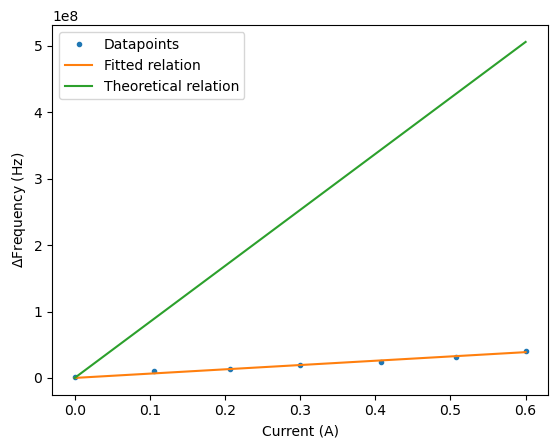

In [29]:
# Creating graph showing fit and theoretical.

import numpy as np


plt.plot(Currents, Frequencies_in_Hz, '.', label="Datapoints")
plt.plot(Currents, LinFit.best_fit, '-', label='Fitted relation')

x = np.linspace(0, 0.6, 2)
plt.plot(x, (lambda x : const*x)(x), label="Theoretical relation")

plt.xlabel("Current (A)")
plt.ylabel("$\Delta$Frequency (Hz)")

plt.legend()

In [37]:
# Linear  oefficient found for displacement
coefficient = Frequencies_in_Hz[6] / Currents[6]
print(coefficient)


68444508.44968985
